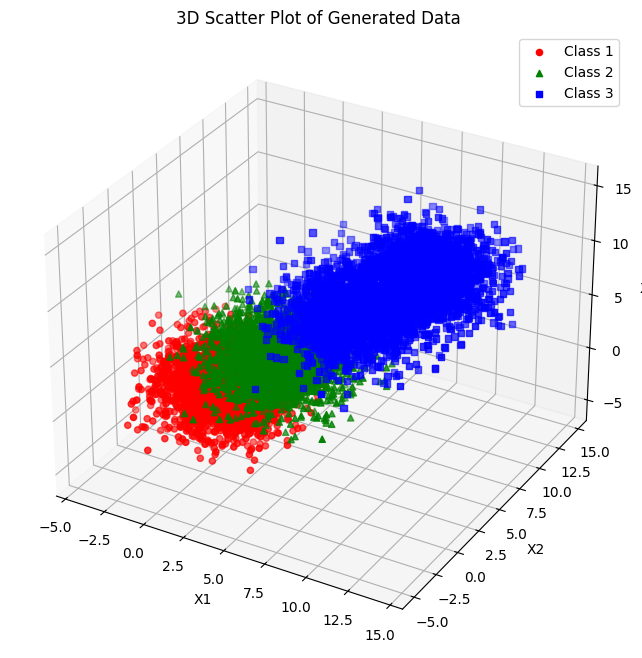

(array([[ 4.05542829,  1.69309262,  2.69522392],
        [ 4.88134088,  4.23470533, -0.69269494],
        [ 2.64560141,  0.73784163,  0.8212197 ],
        ...,
        [10.80013615,  9.2047354 ,  7.67909902],
        [10.04976725,  8.30562473,  7.98596741],
        [ 6.38239264, 10.69194315, 11.17459092]]),
 array([1, 1, 1, ..., 3, 3, 3]))

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

# Define means and covariances for the Gaussians
# mean1 = [0, 0, 0]
# mean2 = [3, 3, 3]
# mean3 = [0, 6, 0]  # Mixture component 1 for class 3
# mean4 = [6, 0, 0]  # Mixture component 2 for class 3
mean1 = [1, 1, 1]
mean2 = [3, 3, 3]
mean3 = [6, 6, 6]  # Mixture component 1 for class 3
mean4 = [9, 9, 9]  # Mixture component 2 for class 3
cov1 = cov2 = cov3 = cov4 = np.eye(3) * 3 # Same covariance for simplicity

# Define the class priors
priors = [0.3, 0.3, 0.4]

# Define number of samples
n_samples = 10000

# Generate samples
np.random.seed(0)  # For reproducibility
samples_class1 = np.random.multivariate_normal(mean1, cov1, int(n_samples * priors[0]))
samples_class2 = np.random.multivariate_normal(mean2, cov2, int(n_samples * priors[1]))
samples_class3_part1 = np.random.multivariate_normal(mean3, cov3, int(n_samples * priors[2] / 2))
samples_class3_part2 = np.random.multivariate_normal(mean4, cov4, int(n_samples * priors[2] / 2))
samples_class3 = np.vstack((samples_class3_part1, samples_class3_part2))

# Combine all samples and labels
samples = np.vstack((samples_class1, samples_class2, samples_class3))
labels = np.array([1]*len(samples_class1) + [2]*len(samples_class2) + [3]*len(samples_class3))

# Scatter plot of the generated data
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(samples_class1[:, 0], samples_class1[:, 1], samples_class1[:, 2], c='r', marker='o', label='Class 1')
ax.scatter(samples_class2[:, 0], samples_class2[:, 1], samples_class2[:, 2], c='g', marker='^', label='Class 2')
ax.scatter(samples_class3[:, 0], samples_class3[:, 1], samples_class3[:, 2], c='b', marker='s', label='Class 3')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.legend()
plt.title("3D Scatter Plot of Generated Data")
plt.show()

# Output samples and labels for further processing
samples, labels


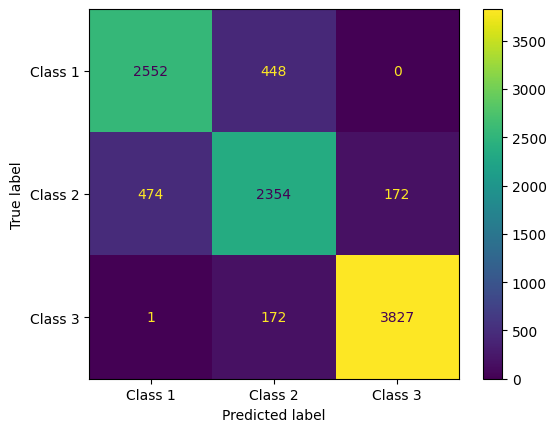

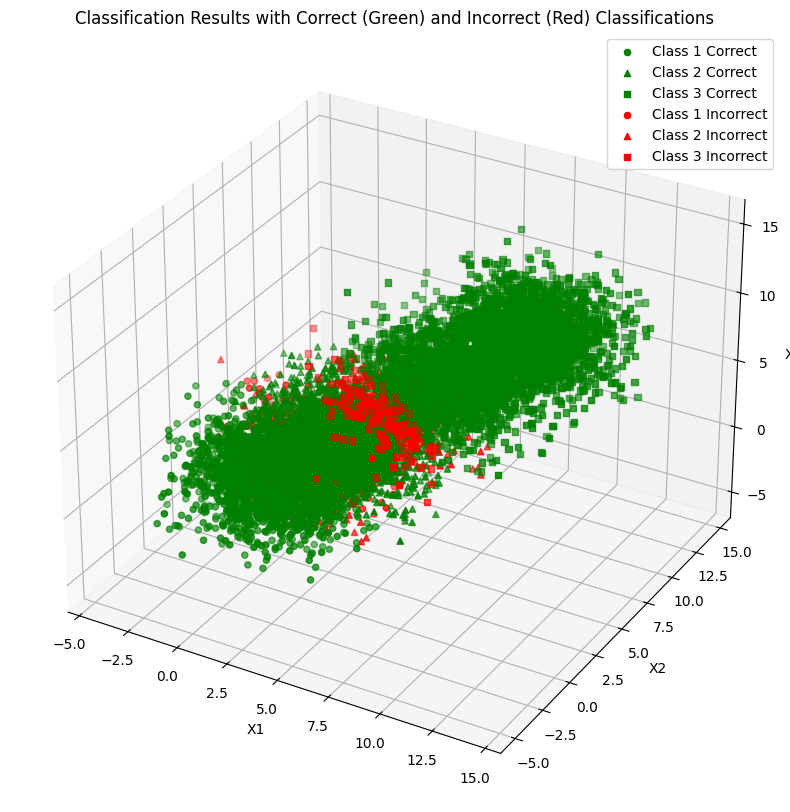

array([[2552,  448,    0],
       [ 474, 2354,  172],
       [   1,  172, 3827]])

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define the pdf for multivariate Gaussian
def gaussian_pdf(x, mean, cov):
    return multivariate_normal(mean=mean, cov=cov).pdf(x)

# Calculate posteriors for each class based on Bayes' rule and classify
def classify(sample):
    posteriors = []
    posteriors.append(gaussian_pdf(sample, mean1, cov1) * priors[0])
    posteriors.append(gaussian_pdf(sample, mean2, cov2) * priors[1])
    # For class 3, need to average the likelihoods from two Gaussians
    likelihood_class3 = 0.5 * gaussian_pdf(sample, mean3, cov3) + 0.5 * gaussian_pdf(sample, mean4, cov4)
    posteriors.append(likelihood_class3 * priors[2])
    return np.argmax(posteriors) + 1  # +1 because classes are 1-based

# Classify all samples
predicted_labels = np.array([classify(sample) for sample in samples])

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predicted_labels, labels=[1, 2, 3])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 1', 'Class 2', 'Class 3'])
disp.plot(cmap='viridis')

# Visualization with correct (green) and incorrect (red) classifications
correct_classifications = labels == predicted_labels
incorrect_classifications = ~correct_classifications


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
# Correctly classified samples
correct_samples_class1 = samples[(labels == 1) & correct_classifications]
correct_samples_class2 = samples[(labels == 2) & correct_classifications]
correct_samples_class3 = samples[(labels == 3) & correct_classifications]

# Incorrectly classified samples
incorrect_samples_class1 = samples[(labels == 1) & incorrect_classifications]
incorrect_samples_class2 = samples[(labels == 2) & incorrect_classifications]
incorrect_samples_class3 = samples[(labels == 3) & incorrect_classifications]

# Plot correctly classified samples
ax.scatter(correct_samples_class1[:, 0], correct_samples_class1[:, 1], correct_samples_class1[:, 2], c='green', marker='o', label='Class 1 Correct')
ax.scatter(correct_samples_class2[:, 0], correct_samples_class2[:, 1], correct_samples_class2[:, 2], c='green', marker='^', label='Class 2 Correct')
ax.scatter(correct_samples_class3[:, 0], correct_samples_class3[:, 1], correct_samples_class3[:, 2], c='green', marker='s', label='Class 3 Correct')

# Plot incorrectly classified samples
ax.scatter(incorrect_samples_class1[:, 0], incorrect_samples_class1[:, 1], incorrect_samples_class1[:, 2], c='red', marker='o', label='Class 1 Incorrect')
ax.scatter(incorrect_samples_class2[:, 0], incorrect_samples_class2[:, 1], incorrect_samples_class2[:, 2], c='red', marker='^', label='Class 2 Incorrect')
ax.scatter(incorrect_samples_class3[:, 0], incorrect_samples_class3[:, 1], incorrect_samples_class3[:, 2], c='red', marker='s', label='Class 3 Incorrect')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.legend()
plt.title("Classification Results with Correct (Green) and Incorrect (Red) Classifications")
plt.show()



conf_matrix


### 

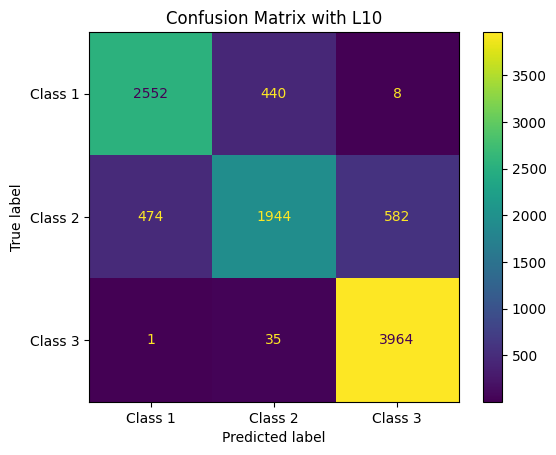

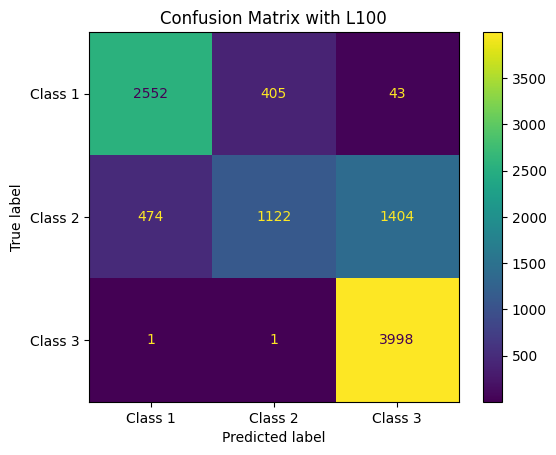

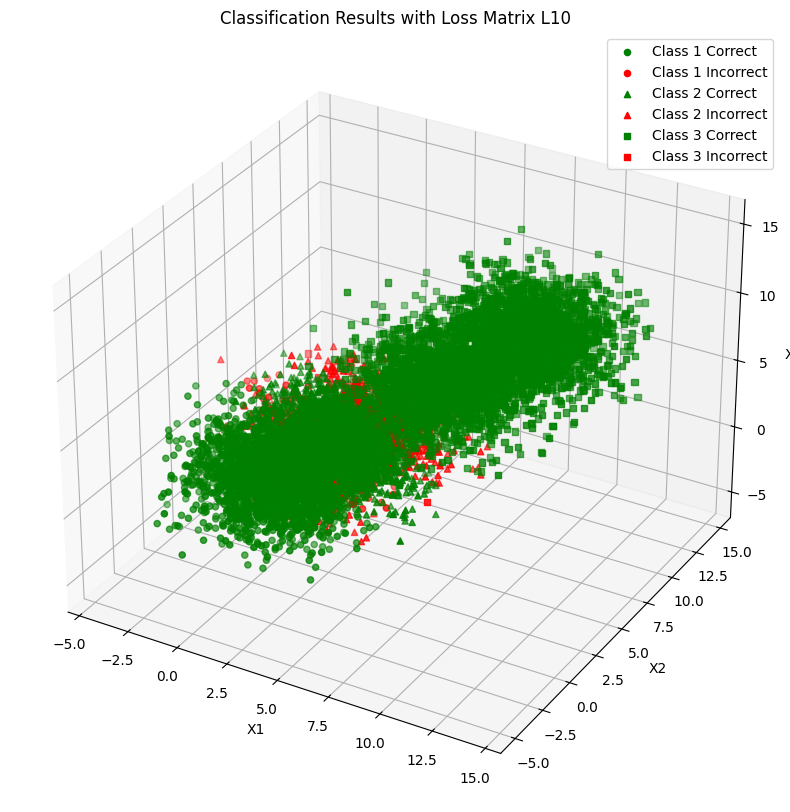

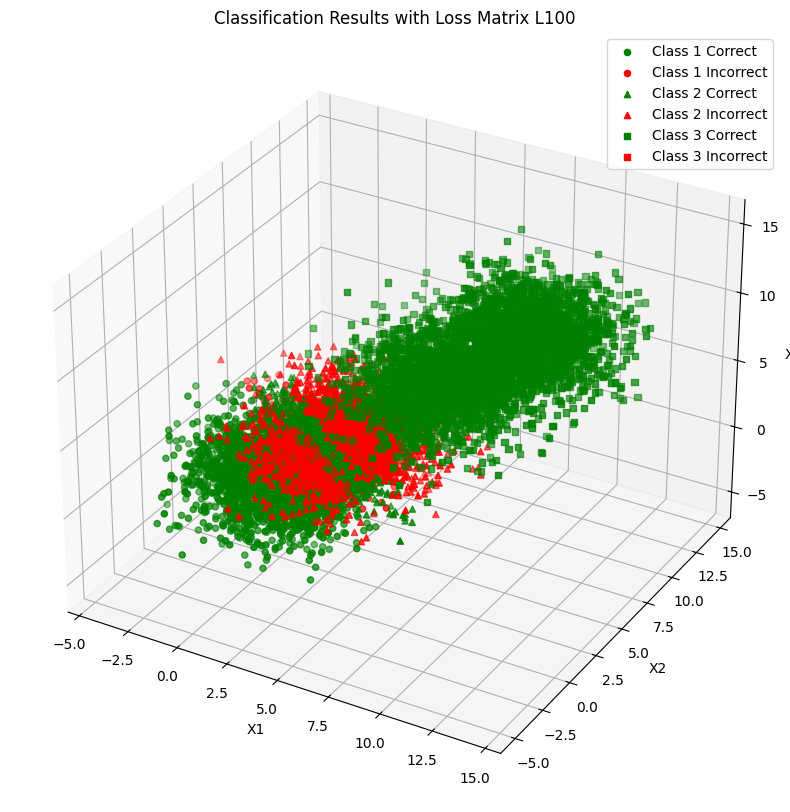

In [43]:
# Function to classify samples based on the ERM decision rule
def erm_classify(sample, loss_matrix):
    costs = []
    # Calculate the cost for each class decision
    for i in range(3):
        cost = 0
        for j in range(3):
            likelihood = gaussian_pdf(sample, globals()[f'mean{j+1}'], globals()[f'cov{j+1}'])
            if j == 2:
                likelihood = 0.5 * (gaussian_pdf(sample, mean3, cov3) + gaussian_pdf(sample, mean4, cov4))
            cost += loss_matrix[i][j] * likelihood * priors[j]
        costs.append(cost)
    return np.argmin(costs) + 1  # Return the class with the minimum expected cost

# Define the loss matrices
L10 = np.array([[0, 1, 10], [1, 0, 10], [1, 1, 0]])
L100 = np.array([[0, 1, 100], [1, 0, 100], [1, 1, 0]])

# Classify samples using ERM with L10
predicted_labels_L10 = np.array([erm_classify(sample, L10) for sample in samples])
conf_matrix_L10 = confusion_matrix(labels, predicted_labels_L10, labels=[1, 2, 3])
disp_L10 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_L10, display_labels=['Class 1', 'Class 2', 'Class 3'])
disp_L10.plot(cmap='viridis')
plt.title('Confusion Matrix with L10')
plt.show()

# Classify samples using ERM with L100
predicted_labels_L100 = np.array([erm_classify(sample, L100) for sample in samples])
conf_matrix_L100 = confusion_matrix(labels, predicted_labels_L100, labels=[1, 2, 3])
disp_L100 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_L100, display_labels=['Class 1', 'Class 2', 'Class 3'])
disp_L100.plot(cmap='viridis')
plt.title('Confusion Matrix with L100')
plt.show()

def plot_classification_results(samples, true_labels, predicted_labels, title):
    correct_classifications = true_labels == predicted_labels
    incorrect_classifications = ~correct_classifications

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot correct classifications in green and incorrect in red
    for class_label, marker in zip([1, 2, 3], ['o', '^', 's']):
        # Correct classifications for this class
        class_samples_correct = samples[(true_labels == class_label) & correct_classifications]
        ax.scatter(class_samples_correct[:, 0], class_samples_correct[:, 1], class_samples_correct[:, 2], c='green', marker=marker, label=f'Class {class_label} Correct')

        # Incorrect classifications for this class
        class_samples_incorrect = samples[(true_labels == class_label) & incorrect_classifications]
        ax.scatter(class_samples_incorrect[:, 0], class_samples_incorrect[:, 1], class_samples_incorrect[:, 2], c='red', marker=marker, label=f'Class {class_label} Incorrect')

    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')
    ax.legend()
    plt.title(title)
    plt.show()

# Visualize the classification results for L10 and L100
plot_classification_results(samples, labels, predicted_labels_L10, "Classification Results with Loss Matrix L10")
plot_classification_results(samples, labels, predicted_labels_L100, "Classification Results with Loss Matrix L100")
